In [1]:
from dtuprosys.mechanistic import YeastModel
from dtuprosys.mechanistic import MassBalance
from dtuprosys.datasets import load_fermentation_hplc_data, load_fermentation_spectra_data
from dtuprosys.chemometrics.models import load_pls_glucose_model
from dtuprosys.chemometrics.preprocessing import RangeCut, Derivative
from dtuprosys.plotting.plot_mechanistic import plot_mechanistic_fermentation

from kineticmodels import Monod
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def stochastic_simulations(mass_balance, nr_simulations, time, initial_values, variances):
    predictions = []
    for j in range(nr_simulations):
        stochastic_conditions = initial_values + np.random.normal(0, variances, 3)
#        if stochastic_conditions[2] < 0:
#            stochastic_conditions[2] = 0
        
        if stochastic_conditions[1] < 0.15:
            stochastic_conditions[1] = 0.15

        if stochastic_conditions[0] < 0:
            stochastic_conditions[0] = 0.0
            
        predicted_values = odeint(mass_balance.calculate, stochastic_conditions, time, full_output=0)
        predictions.append(predicted_values[-2])
        
    predictions = np.array(predictions)
    prior_state = np.mean(predictions, axis=0)
    prior_variance= np.std(predictions, axis=0)

    return prior_state, prior_variance, predictions

In [3]:
spectra = load_fermentation_spectra_data()
range_cut = RangeCut(950,1550)
derivate = Derivative(1,15,1)

spectra_rangecut = range_cut.apply_to(spectra.iloc[12:,:])
spectra_derivate = derivate.apply_to(spectra_rangecut)

pls = load_pls_glucose_model()

In [4]:
yeast_model = YeastModel(model_type='monod_non_competitive', substrate_biomass_yield=0.4, substrate_product_yield=0.51, max_uptake_rate=0.55, affinity_constant=0.1, substrate_inhibition_constant=5) 
mass_balance = MassBalance(yeast_model, 0, 0)

In [5]:
initial_conditions = np.array([40, 0.45, 0])

start_time = 0
current_time = start_time
initial_variance = np.array([10.0, 0.10, 0.10])
end_time = 35

measurement_variance = 0.0005


In [6]:
# Step 1: get current state of the system
prior_state = initial_conditions
prior_variance = initial_variance
prior_covariance = np.diag([prior_variance])

prior_states = []
posterior_states = []
prior_variances = []
posterior_variances = []
pls_glucoses = []

posterior_state = initial_conditions
posterior_variance = initial_variance

for i, _ in enumerate(spectra_derivate.iterrows()):
    # Step 1: get current state of the system
    prior_states.append(prior_state)
    prior_variances.append(prior_variance)

    # Step 2: get measurement
    spectrum = spectra_derivate.iloc[i,:].to_numpy().reshape(1, -1)
    measured_glucose = float(pls.predict(spectrum).squeeze())
    pls_glucoses.append(measured_glucose)

    # Step 3: merge the measurement  
    kalman_gain = prior_variance[0] / (prior_variance[0] + measurement_variance)
    posterior_glucose_state = prior_state[0] + kalman_gain * (measured_glucose - prior_state[0])
    posterior_glucose_variance = prior_variance[0] * (1 - kalman_gain)

    posterior_state = prior_state
    posterior_variance = prior_variance

    posterior_state[0] = posterior_glucose_state
    posterior_variance[0] = posterior_glucose_variance

    posterior_states.append(posterior_state)
    posterior_variances.append(posterior_variance)
    
    # Step 4: forecast using MC simulations
    future_time = current_time + 1.28/60
    time = np.linspace(current_time, future_time, 10)
    prior_state, prior_variance, _ = stochastic_simulations(mass_balance, 1000, time, posterior_state, posterior_variance)
    current_time = future_time

In [7]:
time = np.linspace(0, 35, 1617)
model_predictions = odeint(mass_balance.calculate, initial_conditions, time, full_output=0)


In [8]:
hplc_data = load_fermentation_hplc_data()

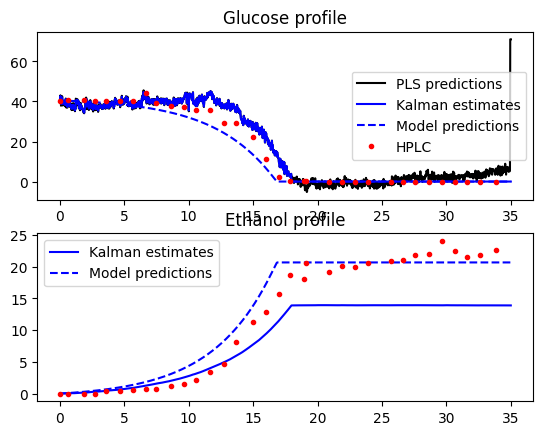

In [9]:
states = np.array(posterior_states).squeeze()
predictions = np.array(model_predictions).squeeze()
fig, ax = plt.subplots(2,1)
ax[0].plot(time, pls_glucoses, 'k', label="PLS predictions")
ax[0].plot(time, states[:,0], 'b', label="Kalman estimates")
ax[0].plot(time, predictions[:,0], 'b--', label="Model predictions")
ax[0].plot(hplc_data.time, hplc_data.glucose, 'ro', markersize=3, label="HPLC")
ax[0].set_title("Glucose profile")
ax[0].legend()

ax[1].plot(time, states[:,2], 'b', label="Kalman estimates")
ax[1].plot(time, predictions[:,2], 'b--', label="Model predictions")
ax[1].plot(hplc_data.time, hplc_data.ethanol, 'ro', markersize=3)
ax[1].set_title("Ethanol profile")
ax[1].legend()
